## ADD global pseudotime kernels to compute cell-cell trans.probs using CellRank2

- Last updated: 08/27/2024
- Author: Yang-Joon Kim



In [29]:
# import libraries
import os
import pandas as pd
import numpy as np
import scanpy as sc
from anndata import AnnData
import glob
import os
import scipy as sp
from scipy import sparse
import cellrank as cr
import scvelo as scv


import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import argparse

import celloracle as co
from celloracle.applications import Oracle_development_module
co.__version__

'0.18.0'

### Step 1. Import the Oracle object and pseudotime values (global)

In [4]:
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/14_TDR126_in_silico_KO_trans_probs_added.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 4602
    n_genes: 3000
    cluster_name: manual_annotation
    dimensional_reduction_name: X_umap_aligned
    n_target_genes_in_TFdict: 13625 genes
    n_regulatory_in_TFdict: 872 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 242 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1735 genes
    k_for_knn_imputation: 115
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [17]:
oracle.adata

AnnData object with n_obs × n_vars = 1244 × 3000
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation', 'Pseudotime', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_t

In [12]:
# 1) "Pseudotime_global" from the integrated object (whole embryo - all celltypes)
# 2) "Pseudotime_global_nmps" from the integrated object (NMP trajectory subsets)
# first, pseudotime computed with "integrated" object - all celltypes
global_pt = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/07_slingshot_processed/integrated_slingshot.csv", 
                        index_col=0)
# second, pseudotime computed with "integrated" object, but subsetted for NMP trajectories (celltypes)
global_pt_nmps = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/07_slingshot_processed/integrated_nmps_slingshot.csv", 
                            index_col=0)

# import the "X_lsi_integrated" from the integrated object
lsi_integrated = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_lsi.csv", index_col=0)


In [7]:
# list of all datasets
list_datasets = ["TDR126","TDR127","TDR128",
                 "TDR118","TDR119","TDR125","TDR124"]

In [14]:
adata_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/"
oracle_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/"
basis="umap_aligned"

for data_id in list_datasets:
    # Step 1. Load the datasets (adata and dim.reductions)
    # 1-1. Load the adata object
    adata = sc.read_h5ad(adata_path + f'{data_id}_nmps_manual_annotation.h5ad')

    # 1-2. Load the Oracle object
    # oracle_path = f"/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/{data_id}/"
    oracle = co.load_hdf5(oracle_path + f"{data_id}/" + f'14_{data_id}_in_silico_KO_trans_probs_added.celloracle.oracle')

    # 1-3. compute the k-nn
    # subset the LSI embedding to the cells in the adata
    lsi_integrated_sub = lsi_integrated[lsi_integrated.index.isin(adata.obs_names)]

    # take the 2nd to 40th columns (dropping the 1st LSI component)
    lsi_integrated_sub_filtered = lsi_integrated_sub.iloc[:,1:40]

    # make sure that the indicies match between the lsi and adata
    lsi_integrated_sub_filtered = lsi_integrated_sub_filtered.reindex(adata.obs.index)

    # Add the LSI embedding to the adata
    adata.obsm["X_lsi_integrated"] = lsi_integrated_sub_filtered.to_numpy()
    
    # NOTE. CellRank requires adata.obsp["connectivities"] to be present
    sc.pp.neighbors(adata, use_rep="X_lsi_integrated")
    
    # Step 2. (WT) Compute the cell-cell transition probabilities using
    # the Pseudotime (computed by pySlingshot)
    # First, transfer the "Pseudotime" from the Oracle.adata to the "adata" object
    adata.obs["Pseudotime"] = oracle.adata.obs["Pseudotime"]
    
    # subset the pseudotime for specific dataset (using "cell_id")
    global_pt_sub = global_pt[global_pt.index.isin(adata.obs_names)]
    global_pt_nmps_sub = global_pt_nmps[global_pt_nmps.index.isin(adata.obs_names)]

    # transfer the "Pseudotime_global" from the Oracle.adata to the "adata" object
    adata.obs["Pseudotime_global"] = global_pt_sub["Pseudotime"]
    adata.obs["Pseudotime_global_nmps"] = global_pt_nmps_sub["Pseudotime"]

    # 2-1. k-nn graph:computing the nearest-neighborhood using the "integrated_lsi"
    # NOTE. CellRank requires adata.obsp["connectivities"] to be present
    # sc.pp.neighbors(adata, use_rep="X_lsi_integrated")

    # Use CellRank's "PseudotimeKernel" to compute the cell-cell transition probabilities
    # compute a transition matrix using the "PseudotimeKernel"
    # "local" Pseudotime
    pk = cr.kernels.PseudotimeKernel(adata, time_key="Pseudotime")
    pk.compute_transition_matrix()

    # pseudotime_global
    pk_global = cr.kernels.PseudotimeKernel(adata, time_key="Pseudotime_global")
    pk_global.compute_transition_matrix()

    # pseudotime_global_nmps
    pk_global_nmps = cr.kernels.PseudotimeKernel(adata, time_key="Pseudotime_global_nmps")
    pk_global_nmps.compute_transition_matrix()

    #extract the trans_probs for the WT (PseudotimeKernel)
    trans_probs_WT_pt = pk.transition_matrix
    trnas_probs_WT_global = pk_global.transition_matrix
    trans_probs_WT_global_nmps = pk_global_nmps.transition_matrix
    
    # generate the 2D projection of the metacell transitions with weighted vectors
    # NOTE. this saves adata.obsm["{key_added}_{"basis"}"]
    # for the 2D projection of cell-cell trans.probs at single-cell level (cells-by-(x,y))
    # NOTE. this also saves adata.obsp["T_fwd_{"basis"}"] to save the cell-cell trans.probs
    pk.plot_projection(basis="umap_aligned", recompute=True, stream=False, scale=0.5, key_added="WT")
    # NOTE. this saves adata.obsm["{key_added}_{"basis"}"] to be averaged/smoothed later either at k-nn, or metacells
    # Repeat this for the global pseudotime
    pk_global.plot_projection(basis="umap_aligned", recompute=True, stream=False, scale=0.5, key_added="WT_global")
    pk_global_nmps.plot_projection(basis="umap_aligned", recompute=True, stream=False, scale=0.5, key_added="WT_global_nmps")


    # update the Oracle object with the "adata" (for pseudotime-derived cell-cell trans.probs and 2D projections)
    # oracle.adata = adata.copy()
    oracle.adata.obsp["connectivities"] = adata.obsp["connectivities"]
    oracle.adata.obsp[f"T_fwd_WT"] = trans_probs_WT_pt
    oracle.adata.obsm[f"WT_{basis}"] = adata.obsm[f"WT_{basis}"]
    # ADD the global pseudotime
    oracle.adata.obsp[f"T_fwd_WT_global"] = trnas_probs_WT_global
    oracle.adata.obsm[f"WT_global_{basis}"] = adata.obsm[f"WT_global_{basis}"]
    # ADD the global pseudotime (NMPs)
    oracle.adata.obsp[f"T_fwd_WT_global_nmps"] = trans_probs_WT_global_nmps
    oracle.adata.obsm[f"WT_global_nmps_{basis}"] = adata.obsm[f"WT_global_nmps_{basis}"]
    
    # Save the Oracle object
    oracle.to_hdf5(oracle_path + f"14_{data_id}_in_silico_KO_trans_probs_added.celloracle.oracle")
    print(f"{data_id} is completed with pseudotime-driven trans.probs")

  0%|          | 0/4602 [00:00<?, ?cell/s]

  0%|          | 0/4602 [00:00<?, ?cell/s]

  0%|          | 0/4602 [00:00<?, ?cell/s]

TDR126 is completed with pseudotime-driven trans.probs


  0%|          | 0/5304 [00:00<?, ?cell/s]

  0%|          | 0/5304 [00:00<?, ?cell/s]

  0%|          | 0/5304 [00:00<?, ?cell/s]

TDR127 is completed with pseudotime-driven trans.probs


  0%|          | 0/2627 [00:00<?, ?cell/s]

  0%|          | 0/2627 [00:00<?, ?cell/s]

  0%|          | 0/2627 [00:00<?, ?cell/s]

TDR128 is completed with pseudotime-driven trans.probs


  0%|          | 0/3363 [00:00<?, ?cell/s]

  0%|          | 0/3363 [00:00<?, ?cell/s]

  0%|          | 0/3363 [00:00<?, ?cell/s]

TDR118 is completed with pseudotime-driven trans.probs


  0%|          | 0/2699 [00:00<?, ?cell/s]

  0%|          | 0/2699 [00:00<?, ?cell/s]

  0%|          | 0/2699 [00:00<?, ?cell/s]

TDR119 is completed with pseudotime-driven trans.probs


  0%|          | 0/4283 [00:00<?, ?cell/s]

  0%|          | 0/4283 [00:00<?, ?cell/s]

  0%|          | 0/4283 [00:00<?, ?cell/s]

TDR125 is completed with pseudotime-driven trans.probs


  0%|          | 0/1244 [00:00<?, ?cell/s]

  0%|          | 0/1244 [00:00<?, ?cell/s]

  0%|          | 0/1244 [00:00<?, ?cell/s]

TDR124 is completed with pseudotime-driven trans.probs


### test with visualization

In [20]:
oracle.adata

AnnData object with n_obs × n_vars = 1244 × 3000
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation', 'Pseudotime', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_t

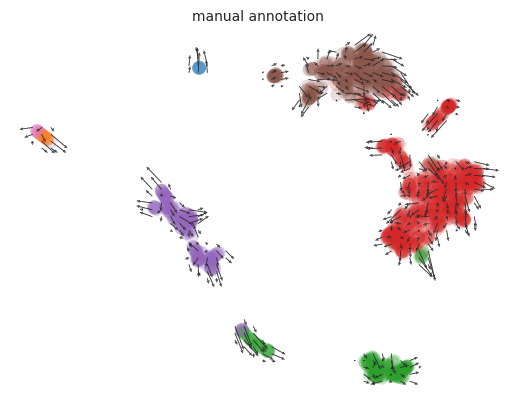

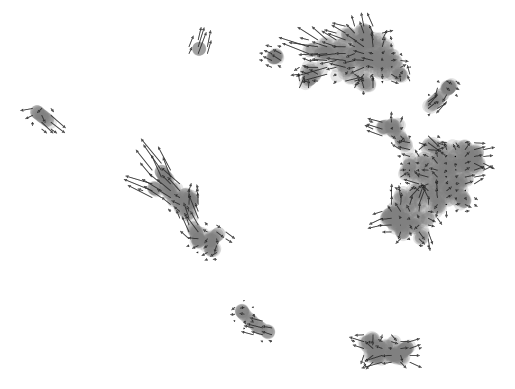

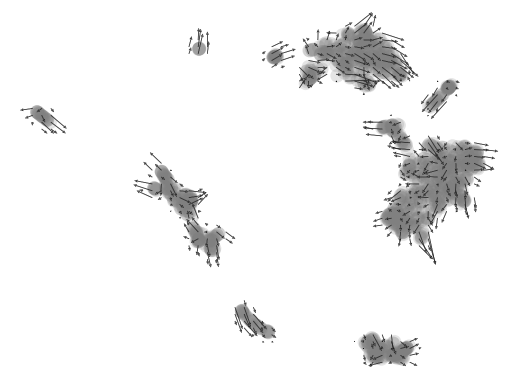

In [47]:
# compute the 2D-projection of the metacell-metacell trans.probs (CellRank functions for "Precomputed_Kernel")
connectivities = oracle.adata.obsp["connectivities"]
precomp_kr_WT = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key="T_fwd_WT")
precomp_kr_WT.plot_projection(basis="umap_aligned", recompute=True, stream=False, 
                                scale=0.5, connectivities=connectivities, color="manual_annotation")

precomp_kr_WT_global = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key="T_fwd_WT_global")
precomp_kr_WT_global.plot_projection(basis="umap_aligned", recompute=True, stream=False, 
                                scale=0.5, connectivities=connectivities)

precomp_kr_WT_global_nmps = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key="T_fwd_WT_global_nmps")
precomp_kr_WT_global_nmps.plot_projection(basis="umap_aligned", recompute=True, stream=False, 
                                scale=0.5, connectivities=connectivities)

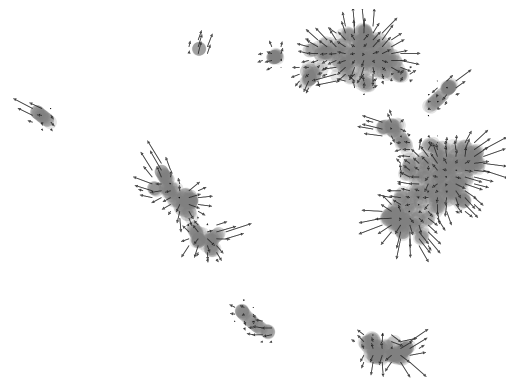

In [44]:
# Check for the KOs
KO_gene = "pax6a"
precomp_kr_KO = cr.kernels.PrecomputedKernel(oracle.adata, obsp_key=f"T_fwd_{KO_gene}_KO")
precomp_kr_KO.plot_projection(basis="umap_aligned", recompute=True, stream=False, 
                                scale=0.5, connectivities=connectivities)